In [1]:
# Combining Attention values across heads - Avg
# Combining Attention values across layers - Matrix Multiply

# Setup

In [2]:
# !pip install dgl torch_geometric torch

# Install required python libraries
import os

# Install PyTorch Geometric and other libraries
# if 'IS_GRADESCOPE_ENV' not in os.environ:
#     print("Installing PyTorch Geometric")
#     !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
#     !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
#     !pip install -q torch-geometric
#     print("Installing other libraries")
#     !pip install networkx
#     !pip install lovely-tensors

In [3]:
import os
import sys
import time
import math
import random
import itertools
from datetime import datetime
from typing import Mapping, Tuple, Sequence, List

import pandas as pd
import networkx as nx
import numpy as np
import scipy as sp

from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F
from torch.nn import Embedding, Linear, ReLU, BatchNorm1d, LayerNorm, Module, ModuleList, Sequential
from torch.nn import TransformerEncoder, TransformerEncoderLayer, MultiheadAttention
from torch.optim import Adam

import torch_geometric
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import Planetoid

import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, dense_to_sparse, to_dense_batch, to_dense_adj

from torch_geometric.nn import GCNConv, GATConv, GATv2Conv

# from torch_scatter import scatter, scatter_mean, scatter_max, scatter_sum

import lovely_tensors as lt
lt.monkey_patch()

import matplotlib.pyplot as plt
import seaborn as sns

# import warnings
# warnings.filterwarnings("ignore", category=RuntimeWarning)
# warnings.filterwarnings("ignore", category=UserWarning)
# warnings.filterwarnings("ignore", category=FutureWarning)

print("All imports succeeded.")
print("Python version {}".format(sys.version))
print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))

D:\PyCharmProjects\Graph_Attention_Interpretability\.venv\Lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
D:\PyCharmProjects\Graph_Attention_Interpretability\.venv\Lib\site-packages\torch_geometric\typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


All imports succeeded.
Python version 3.11.7 (tags/v3.11.7:fa7a6f2, Dec  4 2023, 19:24:49) [MSC v.1937 64 bit (AMD64)]
PyTorch version 2.6.0+cu118
PyG version 2.6.1


In [4]:
# Set random seed for deterministic results

def seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed(0)
print("All seeds set.")

All seeds set.


In [5]:
print("Cuda available: {}".format(torch.cuda.is_available()))

Cuda available: True


# Datasets

In [6]:
# use igraph because much faster than networkx
import igraph as ig
from tqdm import tqdm

def add_position_info(dataset, pe_dim=16):
    
    processed_dataset = []
    pe_transform = T.AddLaplacianEigenvectorPE(k=pe_dim, attr_name='pos_enc')

    for data in tqdm(dataset, total=len(dataset), desc='Processing disjoint graphs'):
        num_nodes = data.num_nodes
        edge_index = data.edge_index

        # Convert to igraph
        edges = edge_index.t().tolist()
        g = ig.Graph(n=num_nodes, edges=edges, directed=False)

        # compute shortest path distances
        sp_matrix = torch.tensor(g.distances(algorithm="johnson"), dtype=torch.float16)
        sp_matrix[torch.isinf(sp_matrix)] = 0
        data.dense_sp_matrix = sp_matrix

        dense_adj = to_dense_adj(edge_index, max_num_nodes=num_nodes)[0]
        dense_adj = dense_adj + torch.eye(num_nodes, dtype=dense_adj.dtype)
        dense_adj[dense_adj == 2] = 1  # remove double self-loops
        data.dense_adj = dense_adj

        # add Laplacian eigenvectors as positional encoding
        data = pe_transform(data)

        processed_dataset.append(data)

    return processed_dataset

In [7]:
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader

train = add_position_info(PPI(root='/tmp/PPI', split='train'))
val = add_position_info(PPI(root='/tmp/PPI', split='val'))
test = add_position_info(PPI(root='/tmp/PPI', split='test'))

train = DataLoader(train, batch_size=1, shuffle=True)
val = DataLoader(val, batch_size=1)
test = DataLoader(test, batch_size=1)

Processing disjoint graphs: 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


In [8]:
data = next(iter(train))

In [9]:
ex_spd = data.dense_sp_matrix
ex_spd.shape

torch.Size([3021, 3021])

In [10]:
tensor_memory_bytes = ex_spd.element_size() * ex_spd.numel()
tensor_memory_MB = tensor_memory_bytes / (1024 ** 2)  # Convert to MB
print(f"Tensor memory usage: {tensor_memory_MB:.2f} MB")

Tensor memory usage: 17.41 MB


In [11]:
data

DataBatch(x=[3021, 50], edge_index=[2, 91338], y=[3021, 121], dense_sp_matrix=[3021, 3021], dense_adj=[3021, 3021], pos_enc=[3021, 16], batch=[3021], ptr=[2])

## Table 1: Dataset Statistics

In [12]:
# ### Table 1 ###
# ### Dataset Statistics ###
# import dgl
# Homophily_Levels = []
# 
# for data in train:
#   edge_index_tensor = torch.tensor(data.edge_index.cpu().numpy(), dtype=torch.long)
#   g = dgl.graph((edge_index_tensor[0], edge_index_tensor[1]), num_nodes=data.x.shape[0])
#   g.ndata['y'] = torch.tensor(data.y.cpu().numpy(), dtype=torch.long)
#   Homophily_Levels.append({'Node Homophily':dgl.node_homophily(g, g.ndata['y'])*100,
#                                 'Edge Homophily':dgl.edge_homophily(g, g.ndata['y'])*100,
#                                 'Adjusted Homophily':dgl.adjusted_homophily(g, g.ndata['y'])*100,
#                                 'Number of Nodes': int(g.num_nodes()),
#                                 'Number of Edges': int(g.num_edges())
#                                 })
# df = pd.DataFrame(Homophily_Levels).round(1)
# df

# Models

In [29]:
EPOCHS = 200
HIDDEN = 512
LR = 2e-3

In [15]:
# PyG example code: https://github.com/pyg-team/pytorch_geometric/blob/master/examples/gcn2_cora.py

class GNNModel(Module):

    def __init__(
            self,
            in_dim: int = data.x.shape[-1],
            hidden_dim: int = HIDDEN,
            num_heads: int = 1,
            num_layers: int = 1,
            out_dim: int = len(data.y.unique()),
            dropout: float = 0.5,
        ):
        super().__init__()

        self.lin_in = Linear(in_dim, hidden_dim)
        self.lin_out = Linear(hidden_dim, out_dim)
        self.layers = ModuleList()

        for layer in range(num_layers):
            self.layers.append(
                GCNConv(hidden_dim, hidden_dim)
            )
        self.dropout = dropout

    def forward(self, x, edge_index):

        x = self.lin_in(x)

        for layer in self.layers:
            # conv -> activation ->  dropout -> residual
            x_in = x
            x = layer(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, self.dropout, training=self.training)
            x = x_in + x

        x = self.lin_out(x)
        # return x.log_softmax(dim=-1)
        return x


class SparseGraphTransformerModel(Module):
    def __init__(
            self,
            in_dim: int = data.x.shape[-1],
            hidden_dim: int = HIDDEN,
            num_heads: int = 1,
            num_layers: int = 1,
            out_dim: int = len(data.y.unique()),
            dropout: float = 0.5,
        ):
        super().__init__()

        self.lin_in = Linear(in_dim, hidden_dim)
        self.lin_out = Linear(hidden_dim, out_dim)

        self.layers = ModuleList()
        for layer in range(num_layers):
            self.layers.append(
                MultiheadAttention(
                    embed_dim = hidden_dim,
                    num_heads = num_heads,
                    dropout = dropout
                )
            )
        self.dropout = dropout
        self.save_attn = False

    def forward(self, x, dense_adj):

        x = self.lin_in(x)

        self.attn_weights_list = []

        for layer in self.layers:
            x_in = x
            x, attn_weights = layer(
                x, x, x,
                attn_mask = ~dense_adj.bool(),
                average_attn_weights = True # the paper already averages so may as well just average here...
            )
            x = F.relu(x)
            x = F.dropout(x, self.dropout, training=self.training)
            x = x_in + x

            if self.save_attn:
                self.attn_weights_list.append(attn_weights)

        x = self.lin_out(x)

        # return x.log_softmax(dim=-1)
        return x

class DenseGraphTransformerModel(Module):

    def __init__(
            self,
            in_dim: int = data.x.shape[-1],
            pos_enc_dim: int = 16,
            hidden_dim: int = HIDDEN,
            num_heads: int = 1,
            num_layers: int = 1,
            out_dim: int = len(data.y.unique()),
            dropout: float = 0.5,
        ):
        super().__init__()

        self.lin_in = Linear(in_dim, hidden_dim)
        self.lin_pos_enc = Linear(pos_enc_dim, hidden_dim)
        self.lin_out = Linear(hidden_dim, out_dim)

        self.layers = ModuleList()
        for layer in range(num_layers):
            self.layers.append(
                MultiheadAttention(
                    embed_dim = hidden_dim,
                    num_heads = num_heads,
                    dropout = dropout
                )
            )

        self.attn_bias_scale = torch.nn.Parameter(torch.tensor([10.0]))  # controls how much we initially bias our model to nearby nodes
        self.dropout = dropout
        self.save_attn = False

    def forward(self, x, pos_enc, dense_sp_matrix):

        # x = self.lin_in(x) + self.lin_pos_enc(pos_enc)
        x = self.lin_in(x)  # no node positional encoding

        # attention bias
        # [i, j] -> inverse of shortest path distance b/w node i and j
        # diagonals -> self connection, set to 0
        # disconnected nodes -> -1
        attn_bias = self.attn_bias_scale * torch.nan_to_num(
            (1 / (torch.nan_to_num(dense_sp_matrix, nan=-1, posinf=-1, neginf=-1))),
            nan=0, posinf=0, neginf=0)
        #attn_bias = torch.ones_like(attn_bias)

        # TransformerEncoder
        # x = self.encoder(x, mask = attn_bias)

        self.attn_weights_list = []

        for layer in self.layers:
            # MHSA layer
            # float mask adds learnable additive attention bias
            x_in = x
            x, attn_weights = layer(
                x, x, x,
                attn_mask = attn_bias,
                average_attn_weights = True    # the paper already averages so may as well just average here...
            )
            x = F.relu(x)
            x = F.dropout(x, self.dropout, training=self.training)
            x = x_in + x

            if self.save_attn:
                self.attn_weights_list.append(attn_weights)

        x = self.lin_out(x)
        # return x.log_softmax(dim=-1)
        return x


class DenseGraphTransformerModel_V2(Module):
    def __init__(
            self,
            in_dim: int = data.x.shape[-1],
            pos_enc_dim: int = 16,
            hidden_dim: int = HIDDEN,
            num_heads: int = 1,
            num_layers: int = 1,
            out_dim: int = len(data.y.unique()),
            dropout: float = 0.5,
        ):
        super().__init__()

        self.lin_in = Linear(in_dim, hidden_dim)
        self.lin_pos_enc = Linear(pos_enc_dim, hidden_dim)
        self.lin_out = Linear(hidden_dim, out_dim)

        self.layers = ModuleList()
        for layer in range(num_layers):
            self.layers.append(
                MultiheadAttention(
                    embed_dim = hidden_dim,
                    num_heads = num_heads,
                    dropout = dropout
                )
            )

        self.attn_bias_scale = torch.nn.Parameter(torch.tensor([10.0]))  # controls how much we initially bias our model to nearby nodes
        self.dropout = dropout
        self.save_attn = False

    def forward(self, x, pos_enc, dense_sp_matrix):

        x = self.lin_in(x) + self.lin_pos_enc(pos_enc)

        self.attn_weights_list = []

        for layer in self.layers:

            # MHSA layer
            # float mask adds learnable additive attention bias
            x_in = x
            x, attn_weights = layer(
                x, x, x,
                average_attn_weights = True # the paper already averages so may as well just average here...
            )
            x = F.relu(x)
            x = F.dropout(x, self.dropout, training=self.training)
            x = x_in + x

            if self.save_attn:
                self.attn_weights_list.append(attn_weights)

        x = self.lin_out(x)

        # return x.log_softmax(dim=-1)
        return x

# Trainers

In [16]:
from sklearn.metrics import f1_score

In [20]:
def Train_GCN(NUM_LAYERS, NUM_HEADS, train_loader, val_loader, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    IN_DIM = train_loader.dataset[0].x.shape[1]
    OUT_DIM = train_loader.dataset[0].y.shape[1]  # 121 for PPI

    model = GNNModel(num_layers=NUM_LAYERS, num_heads=NUM_HEADS, in_dim=IN_DIM, out_dim=OUT_DIM).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    
    loss_fn = torch.nn.BCEWithLogitsLoss()
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=.5)

    def train():
        model.train()
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index)
            loss = loss_fn(out, batch.y.float())  # y is multi-label
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(train_loader)

    def test(loader):
        model.eval()
        y_true, y_pred = [], []
        
        for batch in loader:
            batch = batch.to(device)
            logits = model(batch.x, batch.edge_index)          # or …dense_adj / …spd
            probs  = torch.sigmoid(logits)                     # convert logits → probabilities
            preds  = (probs > 0.5).cpu().numpy().astype(int)   # threshold at 0.5
            y_true.append(batch.y.cpu().numpy())
            y_pred.append(preds)

        y_true = np.vstack(y_true)
        y_pred = np.vstack(y_pred)
        micro_f1 = f1_score(y_true, y_pred, average="micro")
        return micro_f1

    best_val_f1 = test_f1 = 0
    times = []

    for epoch in range(1, EPOCHS):
        start = time.time()
        loss = train()
        scheduler.step()
        train_f1 = test(train_loader)
        val_f1 = test(val_loader)
        tmp_test_f1 = test(test_loader)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            test_f1 = tmp_test_f1

        times.append(time.time() - start)
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss:.4f}, Train: {train_f1:.4f}, Val: {val_f1:.4f}, Test: {test_f1:.4f}')

    return {
        'train_f1': train_f1,
        'val_f1': val_f1,
        'test_f1': test_f1
    }, None


def Train_SparseGraphTransformerModel(NUM_LAYERS, NUM_HEADS, train_loader, val_loader, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Get dimensions from dataset
    IN_DIM = train_loader.dataset[0].x.shape[1]
    OUT_DIM = train_loader.dataset[0].y.shape[1]

    model = SparseGraphTransformerModel(
        num_layers=NUM_LAYERS,
        num_heads=NUM_HEADS,
        in_dim=IN_DIM,
        out_dim=OUT_DIM
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=.5)

    def train():
        model.train()
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.x, batch.dense_adj)
            loss = loss_fn(out, batch.y.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(train_loader)

    def test(loader):
        model.eval()
        y_true, y_pred = [], []

        for batch in loader:
            batch = batch.to(device)
            logits = model(batch.x, batch.dense_adj)          # or …dense_adj / …spd
            probs  = torch.sigmoid(logits)                     # convert logits → probabilities
            preds  = (probs > 0.5).cpu().numpy().astype(int)   # threshold at 0.5
            y_true.append(batch.y.cpu().numpy())
            y_pred.append(preds)

        y_true = np.vstack(y_true)
        y_pred = np.vstack(y_pred)
        micro_f1 = f1_score(y_true, y_pred, average="micro")
        return micro_f1

    best_val_f1 = test_f1 = 0
    times = []

    for epoch in range(1, EPOCHS):
        start = time.time()
        loss = train()
        scheduler.step()
        train_f1 = test(train_loader)
        val_f1 = test(val_loader)
        tmp_test_f1 = test(test_loader)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            test_f1 = tmp_test_f1

        times.append(time.time() - start)

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss:.4f}, Train: {train_f1:.4f}, Val: {val_f1:.4f}, Test: {test_f1:.4f}')

    return {
        'train_f1': train_f1,
        'val_f1': val_f1,
        'test_f1': test_f1
    }, model.cpu()

def Train_DenseGraphTransformerModel(NUM_LAYERS, NUM_HEADS, train_loader, val_loader, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    IN_DIM = train_loader.dataset[0].x.shape[1]
    OUT_DIM = train_loader.dataset[0].y.shape[1]

    model = DenseGraphTransformerModel(
        num_layers=NUM_LAYERS,
        num_heads=NUM_HEADS,
        in_dim=IN_DIM,
        out_dim=OUT_DIM
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=.5)
    
    def train():
        model.train()
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.x, batch.pos_enc, batch.dense_sp_matrix)  # batch.spd is dense_sp_matrix
            loss = loss_fn(out, batch.y.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(train_loader)

    def test(loader):
        model.eval()
        y_true, y_pred = [], []

        for batch in loader:
            batch = batch.to(device)
            logits = model(batch.x, batch.pos_enc, batch.dense_sp_matrix)          # or …dense_adj / …spd
            probs  = torch.sigmoid(logits)                     # convert logits → probabilities
            preds  = (probs > 0.5).cpu().numpy().astype(int)   # threshold at 0.5
            y_true.append(batch.y.cpu().numpy())
            y_pred.append(preds)

        y_true = np.vstack(y_true)
        y_pred = np.vstack(y_pred)
        micro_f1 = f1_score(y_true, y_pred, average="micro")
        return micro_f1

    best_val_f1 = test_f1 = 0
    times = []

    for epoch in range(1, EPOCHS):
        start = time.time()
        loss = train()
        scheduler.step()
        train_f1 = test(train_loader)
        val_f1 = test(val_loader)
        tmp_test_f1 = test(test_loader)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            test_f1 = tmp_test_f1

        times.append(time.time() - start)

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss:.4f}, Train: {train_f1:.4f}, Val: {val_f1:.4f}, Test: {test_f1:.4f}')

    return {
        'train_f1': train_f1,
        'val_f1': val_f1,
        'test_f1': test_f1
    }, model.cpu()
    
    # Notes
    # - Dense Transformer needs to be trained for a bit longer to reach low loss value
    # - Node positional encodings are not particularly useful
    # - Edge distance encodings are very useful
    # - Since Cora is highly homophilic, it is important to bias the attention towards nearby nodes

def Train_DenseGraphTransformerModel_V2(NUM_LAYERS, NUM_HEADS, train_loader, val_loader, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    IN_DIM = train_loader.dataset[0].x.shape[1]
    OUT_DIM = train_loader.dataset[0].y.shape[1]

    model = DenseGraphTransformerModel_V2(
        num_layers=NUM_LAYERS,
        num_heads=NUM_HEADS,
        in_dim=IN_DIM,
        out_dim=OUT_DIM
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=.5)
    
    def train():
        model.train()
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.x, batch.pos_enc, batch.dense_sp_matrix)  # batch.spd is dense_sp_matrix
            loss = loss_fn(out, batch.y.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(train_loader)

    def test(loader):
        model.eval()
        y_true, y_pred = [], []

        for batch in loader:
            batch = batch.to(device)
            logits = model(batch.x, batch.pos_enc, batch.dense_sp_matrix)          # or …dense_adj / …spd
            probs  = torch.sigmoid(logits)                     # convert logits → probabilities
            preds  = (probs > 0.5).cpu().numpy().astype(int)   # threshold at 0.5
            y_true.append(batch.y.cpu().numpy())
            y_pred.append(preds)

        y_true = np.vstack(y_true)
        y_pred = np.vstack(y_pred)
        micro_f1 = f1_score(y_true, y_pred, average="micro")
        return micro_f1

    best_val_f1 = test_f1 = 0
    times = []

    for epoch in range(1, EPOCHS):
        start = time.time()
        loss = train()
        scheduler.step()
        train_f1 = test(train_loader)
        val_f1 = test(val_loader)
        tmp_test_f1 = test(test_loader)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            test_f1 = tmp_test_f1

        times.append(time.time() - start)

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss:.4f}, Train: {train_f1:.4f}, Val: {val_f1:.4f}, Test: {test_f1:.4f}')

    return {
        'train_f1': train_f1,
        'val_f1': val_f1,
        'test_f1': test_f1
    }, model.cpu()  # if model tracks attention weights
# Training

## Training

In original paper, the models are re-trained across multiple runs with varying train/test splits. The attention weights are then averaged across runs to get a more robust attention representation that is less affected by train/test splits. 

However, in the inductive setting (20 different graphs), the analysis would need to be averaged for each graph separately, making this computationally expensive.

Additionally, in the inductive setting, the model may be intrinsically more stable (relative to train/test splits) due to generalizing across multiple graphs.

Therefore, we only train a single model for this task and analyze each graph-model combination separately.

In [38]:
NUM_LAYERS = 4
NUM_HEADS = 4

accuracy_statistics = {}
models = {}

# Train all models with the same loaders
accuracy_statistics['GCN'], _ = Train_GCN(NUM_LAYERS, NUM_HEADS, train, val, test)
accuracy_statistics['SparseGraphTransformerModel'], models['SparseGraphTransformerModel'] = Train_SparseGraphTransformerModel(NUM_LAYERS, NUM_HEADS, train, val, test)
accuracy_statistics['DenseGraphTransformerModel'], models['DenseGraphTransformerModel'] = Train_DenseGraphTransformerModel(NUM_LAYERS, NUM_HEADS, train, val, test)
accuracy_statistics['DenseGraphTransformerModel_V2'], models['DenseGraphTransformerModel_V2'] = Train_DenseGraphTransformerModel_V2(NUM_LAYERS, NUM_HEADS, train, val, test)

accuracy_statistics

Epoch 10, Loss: 0.4186, Train: 0.6808, Val: 0.6504, Test: 0.6691
Epoch 20, Loss: 0.3553, Train: 0.7544, Val: 0.7126, Test: 0.7420
Epoch 30, Loss: 0.3202, Train: 0.8127, Val: 0.7689, Test: 0.7962
Epoch 40, Loss: 0.2975, Train: 0.8347, Val: 0.7899, Test: 0.8176
Epoch 50, Loss: 0.2873, Train: 0.8469, Val: 0.8029, Test: 0.8308
Epoch 60, Loss: 0.2784, Train: 0.8574, Val: 0.8135, Test: 0.8415
Epoch 70, Loss: 0.2691, Train: 0.8659, Val: 0.8215, Test: 0.8494
Epoch 80, Loss: 0.2663, Train: 0.8694, Val: 0.8253, Test: 0.8533
Epoch 90, Loss: 0.2624, Train: 0.8746, Val: 0.8304, Test: 0.8582
Epoch 100, Loss: 0.2577, Train: 0.8771, Val: 0.8332, Test: 0.8603
Epoch 110, Loss: 0.2564, Train: 0.8799, Val: 0.8364, Test: 0.8635
Epoch 120, Loss: 0.2550, Train: 0.8811, Val: 0.8371, Test: 0.8644
Epoch 130, Loss: 0.2531, Train: 0.8819, Val: 0.8373, Test: 0.8654
Epoch 140, Loss: 0.2519, Train: 0.8822, Val: 0.8373, Test: 0.8672
Epoch 150, Loss: 0.2509, Train: 0.8839, Val: 0.8396, Test: 0.8675
Epoch 160, Loss: 0.

{'GCN': {'train_f1': 0.8859265045934629,
  'val_f1': 0.8416800630274105,
  'test_f1': 0.8694772608468374},
 'SparseGraphTransformerModel': {'train_f1': 0.8902466071261015,
  'val_f1': 0.8568108683953302,
  'test_f1': 0.878134905895582},
 'DenseGraphTransformerModel': {'train_f1': 0.886219759020709,
  'val_f1': 0.8477365145694322,
  'test_f1': 0.8716827085902498},
 'DenseGraphTransformerModel_V2': {'train_f1': 0.5428683731570324,
  'val_f1': 0.5283488693599373,
  'test_f1': 0.5375886878561542}}

In [30]:
NUM_LAYERS = 3
NUM_HEADS = 8

accuracy_statistics2 = {}
models2 = {}

# Train all models with the same loaders
accuracy_statistics2['GCN'], _ = Train_GCN(NUM_LAYERS, NUM_HEADS, train, val, test)
accuracy_statistics2['SparseGraphTransformerModel'], models2['SparseGraphTransformerModel'] = Train_SparseGraphTransformerModel(NUM_LAYERS, NUM_HEADS, train, val, test)
accuracy_statistics2['DenseGraphTransformerModel'], models2['DenseGraphTransformerModel'] = Train_DenseGraphTransformerModel(NUM_LAYERS, NUM_HEADS, train, val, test)
accuracy_statistics2['DenseGraphTransformerModel_V2'], models2['DenseGraphTransformerModel_V2'] = Train_DenseGraphTransformerModel_V2(NUM_LAYERS, NUM_HEADS, train, val, test)

accuracy_statistics2

Epoch 10, Loss: 0.4284, Train: 0.6545, Val: 0.6257, Test: 0.6459
Epoch 20, Loss: 0.3722, Train: 0.7395, Val: 0.6999, Test: 0.7248
Epoch 30, Loss: 0.3440, Train: 0.7877, Val: 0.7448, Test: 0.7732
Epoch 40, Loss: 0.3253, Train: 0.8071, Val: 0.7642, Test: 0.7919
Epoch 50, Loss: 0.3154, Train: 0.8168, Val: 0.7724, Test: 0.8049
Epoch 60, Loss: 0.3097, Train: 0.8275, Val: 0.7836, Test: 0.8114
Epoch 70, Loss: 0.3018, Train: 0.8344, Val: 0.7899, Test: 0.8196
Epoch 80, Loss: 0.2973, Train: 0.8389, Val: 0.7933, Test: 0.8249
Epoch 90, Loss: 0.2937, Train: 0.8430, Val: 0.7981, Test: 0.8264
Epoch 100, Loss: 0.2912, Train: 0.8452, Val: 0.7997, Test: 0.8306
Epoch 110, Loss: 0.2888, Train: 0.8495, Val: 0.8048, Test: 0.8327
Epoch 120, Loss: 0.2879, Train: 0.8507, Val: 0.8062, Test: 0.8339
Epoch 130, Loss: 0.2869, Train: 0.8511, Val: 0.8066, Test: 0.8343
Epoch 140, Loss: 0.2854, Train: 0.8520, Val: 0.8070, Test: 0.8354
Epoch 150, Loss: 0.2843, Train: 0.8516, Val: 0.8061, Test: 0.8361
Epoch 160, Loss: 0.

{'GCN': {'train_f1': 0.8552367480600795,
  'val_f1': 0.8103124466450401,
  'test_f1': 0.8385251146140138},
 'SparseGraphTransformerModel': {'train_f1': 0.9168029415358827,
  'val_f1': 0.8833965773971975,
  'test_f1': 0.904935296606841},
 'DenseGraphTransformerModel': {'train_f1': 0.9208205625138044,
  'val_f1': 0.8855508027331815,
  'test_f1': 0.9073442794383756},
 'DenseGraphTransformerModel_V2': {'train_f1': 0.545030697677233,
  'val_f1': 0.5311260134552355,
  'test_f1': 0.5397821269157537}}

## Table 2: Accuracy Statistics

In [39]:
### Table 2 ###
### Accuracy Statistics ###
all_stats_df = pd.DataFrame(accuracy_statistics).T.round(2)
all_stats_df

,train_f1,val_f1,test_f1
GCN,0.89,0.84,0.87
SparseGraphTransformerModel,0.89,0.86,0.88
DenseGraphTransformerModel,0.89,0.85,0.87
DenseGraphTransformerModel_V2,0.54,0.53,0.54


In [40]:
all_stats_df2 = pd.DataFrame(accuracy_statistics2).T.round(2)
all_stats_df2

,train_f1,val_f1,test_f1
GCN,0.86,0.81,0.84
SparseGraphTransformerModel,0.92,0.88,0.90
DenseGraphTransformerModel,0.92,0.89,0.91
DenseGraphTransformerModel_V2,0.55,0.53,0.54


## Create Attention Graphs

In [60]:
def create_graph_from_attention(attention_matrix, threshold):
    """Creates a directed graph from an attention matrix."""
    attention_matrix = attention_matrix.numpy() 
    
    # mask out weights below the threshold
    attention_matrix = attention_matrix * (attention_matrix > threshold)
    
    G = nx.from_numpy_array(attention_matrix, create_using=nx.DiGraph())
    
    return G

def get_threshold(attention_matrix, model_name=None):
    """Returns threshold using different percentiles based on model."""
    attn_values = attention_matrix.flatten().cpu().numpy()

    # percentile = 99.5 if model_name == "dt2_avg" else 90
    percentile_threshold = np.percentile(attn_values, 99.5)
    mean_threshold = attn_values.mean() + 1.5 * attn_values.std()

    return max(percentile_threshold, mean_threshold)


In [106]:
from torch_geometric.utils import to_networkx

def generate_attention_graphs(gnns, dataloader, device):
    
    graphs = {}
    
    for model_name, model in gnns.items():
        graphs[model_name] = {}
        model.save_attn = True
        model = model.to(device)

        for idx, g in enumerate(dataloader):
            g = g.to(device)
            
            model.eval()
            with torch.no_grad():
                # Make prediction to save attention weights
                if model_name == 'SparseGraphTransformerModel':
                    model(g.x, g.dense_adj)
                else:
                    model(g.x, g.pos_enc, g.dense_sp_matrix)

            # Retrieve and aggregate attention matrices
            attn_weights = model.attn_weights_list
            attn_graph = attn_weights[0]

            for attn in attn_weights[1:]:
                attn_graph = attn_graph @ attn  # matrix multiplication across layers

            attn_graph = attn_graph.cpu()

            # Threshold and create graph
            threshold = get_threshold(attn_graph)
            attn_graph = create_graph_from_attention(attn_graph, threshold)

            # Convert original PyG graph to NetworkX graph
            og_graph = to_networkx(g, to_undirected=False)

            graphs[model_name][idx] = {
                "original_graph": og_graph,
                "attention_graph": attn_graph
            }

    return graphs

In [107]:
from torch.utils.data import ConcatDataset

combined_data = ConcatDataset([train.dataset, val.dataset, test.dataset])
combined_loader = DataLoader(combined_data, batch_size=1, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [108]:
graphs_44 = generate_attention_graphs(models, combined_loader, device)

In [110]:
graphs_38 = generate_attention_graphs(models2, combined_loader, device)

# Analysis


In [49]:
from scipy.stats import spearmanr

def compute_metrics(G):
    return pd.DataFrame.from_dict({
        'degree': nx.degree_centrality(G),
        'betweenness': nx.betweenness_centrality(G, normalized=True),
        'closeness': nx.closeness_centrality(G),
        'eigenvector': nx.eigenvector_centrality(G, max_iter=500, tol=1e-02),
        'clustering': nx.clustering(G),
        'pagerank': nx.pagerank(G, alpha=0.85)
    })

def compute_cross_metric_correlation(metrics1, metrics2):
    metrics1 = pd.DataFrame(metrics1)
    metrics2 = pd.DataFrame(metrics2)
    
    result = pd.DataFrame(index=metrics1.columns, columns=metrics2.columns)
    
    for col1 in metrics1.columns:
        for col2 in metrics2.columns:
            corr, _ = spearmanr(metrics1[col1], metrics2[col2])
            result.loc[col1, col2] = corr

    return result.astype(float)
def corr_heatmap(corr_df, title):
    plt.figure(figsize=(10, 7))
    sns.heatmap(corr_df, annot=True, fmt=".2f", vmin=-1, vmax=1, cmap='coolwarm', cbar=True)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

def topk_overlap(metrics1, metrics2, label1, label2, out_path):
    def get_top_k_nodes(metric_dict, k=100):
        return {
            metric: set(sorted(metric_dict[metric].items(), key=lambda x: x[1], reverse=True)[:k])
            for metric in metric_dict
        }

    topk_1 = get_top_k_nodes(metrics1)
    topk_2 = get_top_k_nodes(metrics2)

    with open(out_path, "w") as f:
        f.write(f"Top-100 Node Overlap Between {label1} and {label2}\n")
        for metric in metrics1:
            nodes_1 = {node for node, _ in topk_1[metric]}
            nodes_2 = {node for node, _ in topk_2[metric]}



In [50]:
def analyze_graphs(model_stats, model_name):
    total_nodes = 0
    corr_df = None
    for g_idx, g in tqdm(model_stats.items(), total=len(model_stats)):
        og_graph = g['original_graph']
        attn_graph = g['attention_graph']
        
        num_nodes = og_graph.number_of_nodes()
        total_nodes += num_nodes
        
        og_graph_stats = compute_metrics(og_graph)
        attn_graph_stats = compute_metrics(attn_graph)
        
        corr = compute_cross_metric_correlation(og_graph_stats, attn_graph_stats)
        corr *= num_nodes
        if corr_df is None:
            corr_df = corr
        else:
            corr_df += corr
        
    corr_df /= total_nodes 
    
    corr_heatmap(corr_df, title=model_name)

## 4 Layers, 4 Heads Analysis

In [ ]:
sparse = list(graphs_44.keys())[0]
analyze_graphs(graphs_44[sparse], f"{sparse}_4x4")

In [ ]:
dlb = list(graphs_44.keys())[0]
analyze_graphs(graphs_44[dlb], f"{dlb}_4x4")

## 3 Layers, 8 Heads Analysis

100%|██████████| 24/24 [15:18<00:00, 38.27s/it]


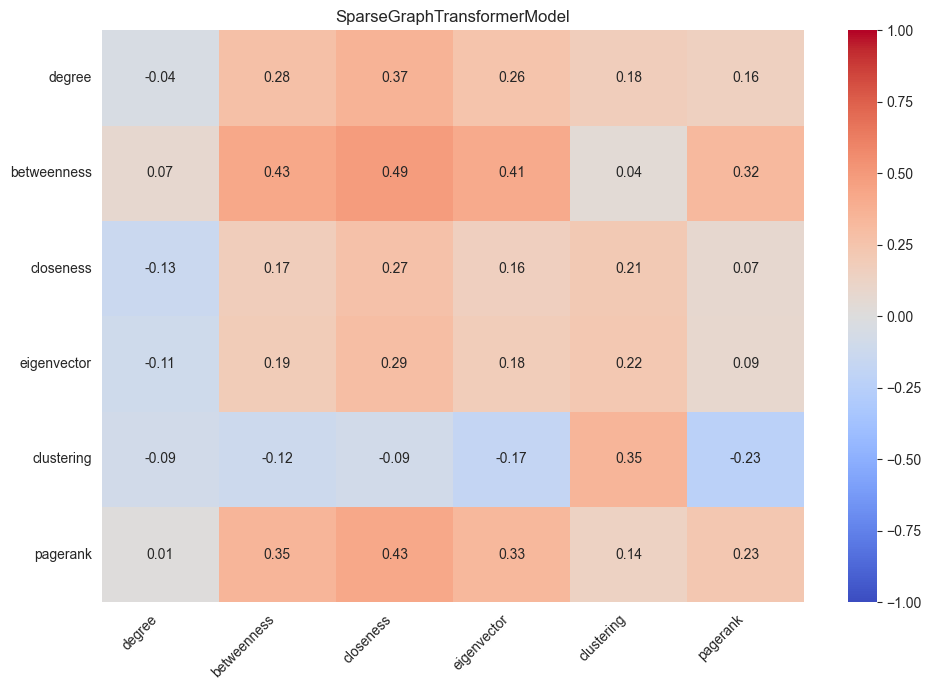

In [37]:
sparse2 = list(graphs_38.keys())[0]
analyze_graphs(graphs_38[sparse2], f"{sparse2}_3x8")

100%|██████████| 24/24 [17:34<00:00, 43.93s/it]


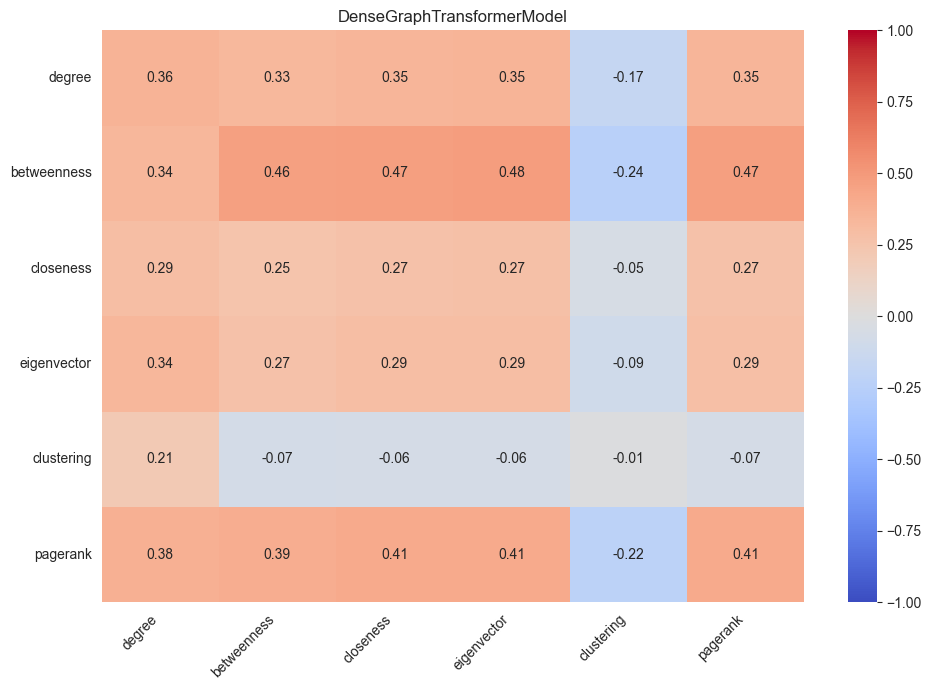

In [114]:
dlb2 = list(graphs_38.keys())[1]
analyze_graphs(graphs_38[dlb2], f"{dlb2}")

In [ ]:
# dl2 = list(graphs_38.keys())[2]
# analyze_graphs(graphs_38[dl2], f"{dl2}")

## Local Graph Analysis/Comparisons

In [136]:
list(test)

[DataBatch(x=[3224, 50], edge_index=[2, 100648], y=[3224, 121], dense_sp_matrix=[3224, 3224], dense_adj=[3224, 3224], pos_enc=[3224, 16], batch=[3224], ptr=[2]),
 DataBatch(x=[2300, 50], edge_index=[2, 61328], y=[2300, 121], dense_sp_matrix=[2300, 2300], dense_adj=[2300, 2300], pos_enc=[2300, 16], batch=[2300], ptr=[2])]

In [124]:
local_38 = {dlb2: models2[dlb2]}
local_38

{'DenseGraphTransformerModel': DenseGraphTransformerModel(
   (lin_in): Linear(in_features=50, out_features=512, bias=True)
   (lin_pos_enc): Linear(in_features=16, out_features=512, bias=True)
   (lin_out): Linear(in_features=512, out_features=121, bias=True)
   (layers): ModuleList(
     (0-2): 3 x MultiheadAttention(
       (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
     )
   )
 )}

In [125]:
# val contains the two largest graphs in 
local_graphs_38 = generate_attention_graphs(local_38, test, device)

In [130]:
local_graphs_38 = local_graphs_38[dlb2]

100%|██████████| 1/1 [01:21<00:00, 81.30s/it]


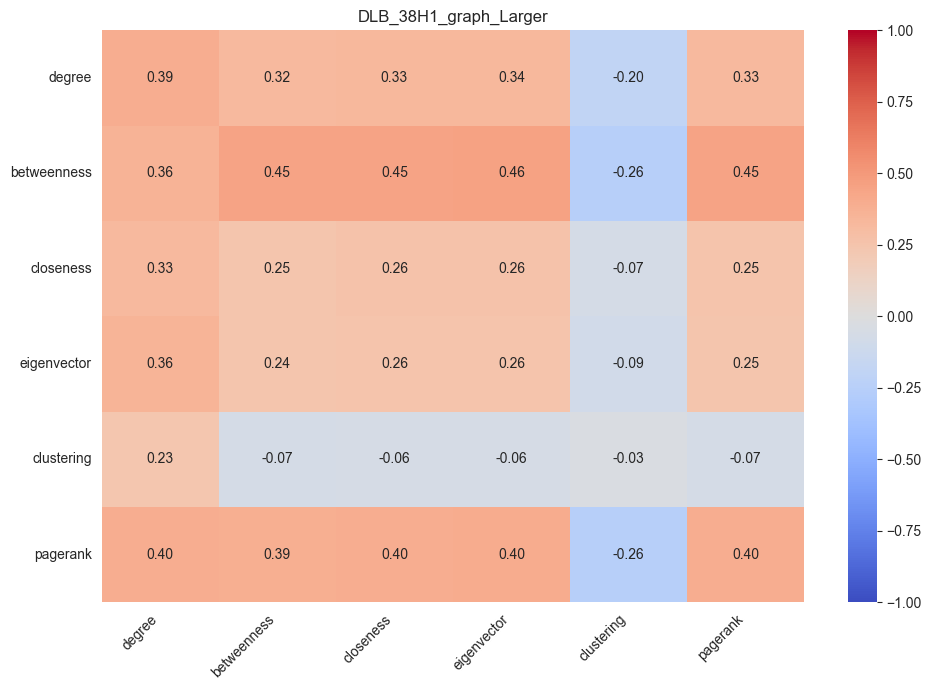

In [137]:
analyze_graphs({k: v for i, (k, v) in enumerate(local_graphs_38.items()) if i == 0}, f"DLB_38H1_graph_Larger")

100%|██████████| 1/1 [01:20<00:00, 80.11s/it]


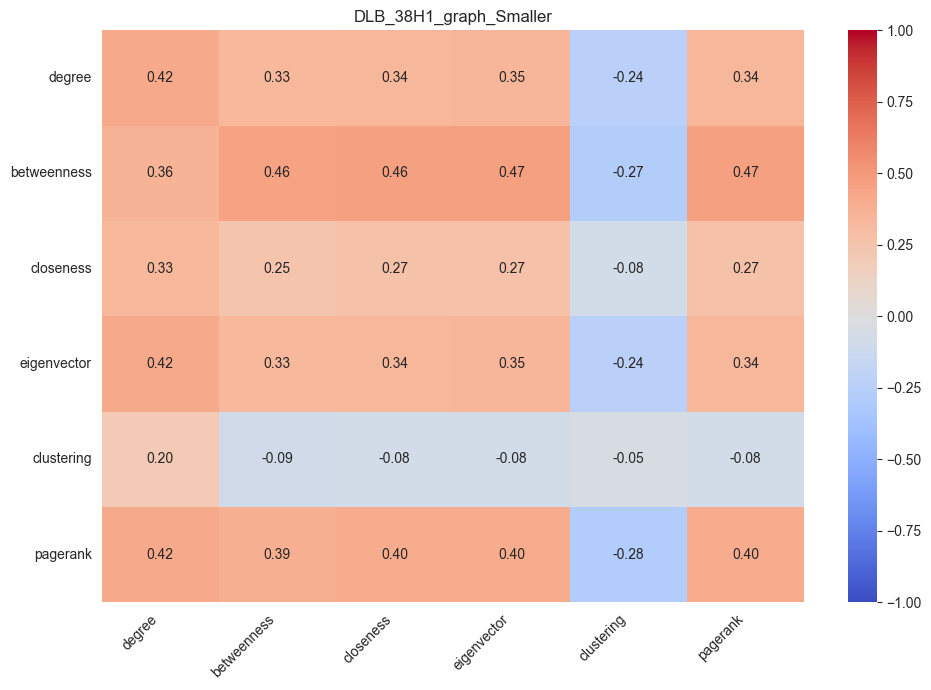

In [138]:
analyze_graphs({k: v for i, (k, v) in enumerate(local_graphs_38.items()) if i == 1}, f"DLB_38H1_graph_Smaller")